# Technical test  Detection and classification of “salad & fruit bar” 

## references

https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55

https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/object_localization_and_detection.html

https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/

https://theaisummer.com/Localization_and_Object_Detection/

https://medium.com/analytics-vidhya/image-classification-vs-object-detection-vs-image-segmentation-f36db85fe81

https://arxiv.org/pdf/1807.05511.pdf

http://www.huppelen.nl/publications/selectiveSearchDraft.pdf

https://github.com/kbardool/keras-frcnn

https://towardsdatascience.com/evaluating-performance-of-an-object-detection-model-137a349c517b

https://github.com/rafaelpadilla/Object-Detection-Metrics

This problem is a detection and classification problem, given an image of meal trays we have to detect and localize containers of “salad & fruit bar” and classify them as <b>small_vrac</b> or <b>big_vrac</b>.  Many approaches could be considered to detect, localize and classify the objects. According to me the most powerful and flexible one would be to use deep learning models to build a process responding to the issue. Moreover, a set of images already labelled is provided enabling a training over this dataset. 

If there was only one object to localize by images, I would compute a regression over a convolutional neural network that output the 4 coordinates of a square around the "salad & fruit bar". The point here is that there could be different amount of "salad & fruit bar" so we have to make the system intolerant to the number of objects to detect. 

In [1]:
# import
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import patches
import time
import glob

#Variable definitions
current_working_directory = os.getcwd()
image_directory = current_working_directory + '\\images\\'


## Data exploration

In [2]:
# Collect dataset

# Collect images from file

# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


dataset_temp = np.load(current_working_directory + '\\test_db.npy')
print('size of dataset, number of images :',dataset_temp.shape)


# Collect all boxes
dataset =[]
for data in dataset_temp:
    dataset += [{**box,**{'img':data['name']}} for box in data['boxes']]
    
print('size of dataset, number of boxes :',len(dataset))


# Transform in pandas Dataframe
df = pd.DataFrame(dataset)
df

size of dataset, number of images : (1000,)
size of dataset, number of boxes : 1212


,box,is_background,id,box_id,img
0,"[49, 202, 172, 172]",False,big_vrac,2019_01_23_169,im_0.jpg
1,"[65, 131, 179, 179]",False,big_vrac,2018_08_23_988,im_1.jpg
2,"[20, 0, 161, 135]",False,big_vrac,2019_01_11_72,im_2.jpg
3,"[0, 98, 140, 173]",False,small_vrac,2018_11_16_111,im_3.jpg
4,"[6, 53, 142, 155]",False,small_vrac,2019_01_22_127,im_4.jpg
...,...,...,...,...,...
1207,"[419, 19, 142, 142]",False,small_vrac,2018_10_24_49,im_996.jpg
1208,"[338, 176, 162, 157]",False,small_vrac,2018_08_02_0,im_997.jpg
1209,"[88, 141, 186, 168]",False,big_vrac,2018_08_02_1,im_997.jpg
1210,"[360, 84, 164, 164]",False,small_vrac,2018_11_16_164,im_998.jpg


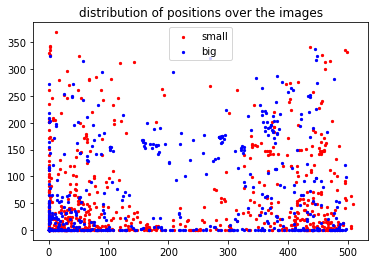

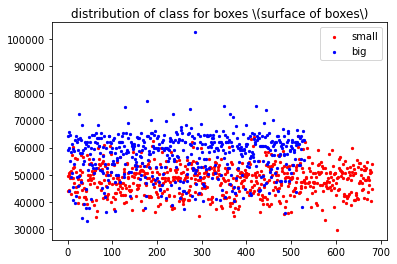

In [3]:
# Study the dataset


# positions
plt.scatter(df[df['id'] == 'small_vrac']['box'].map(lambda x : x[0]).tolist(),
            df[df['id'] == 'small_vrac']['box'].map(lambda x : x[1]).tolist(), 
            s=5,c="r")
plt.scatter(df[df['id'] == 'big_vrac']['box'].map(lambda x : x[0]).tolist(),
            df[df['id'] == 'big_vrac']['box'].map(lambda x : x[1]).tolist(), 
            s=5,c="b")
plt.title('distribution of positions over the images')
plt.legend(['small','big'])
plt.show()

# sizes

plt.scatter([i for i in range(df[df['id'] == 'small_vrac']['box'].count())],
            df[df['id'] == 'small_vrac']['box'].map(lambda x : x[-2]**2 + x[-1]**2 ).tolist(), s=5,c="r")
plt.scatter([i for i in range(df[df['id'] == 'big_vrac']['box'].count())],
            df[df['id'] == 'big_vrac']['box'].map(lambda x : x[-2]**2 + x[-1]**2 ).tolist(), s=5,c="b")
plt.title('distribution of class for boxes \(surface of boxes\)')
plt.legend(['small','big'])
plt.show()

In [4]:
# Plot image
def image_plot(image_folder, image_name,):
    """
    This function can be used to plot images with object and classes.
    image_folder : the folder where the image can be found
    image_name : the name of the jpg file of the image
    """
    fig = plt.figure()

    # Add axes to the image
    ax = fig.add_axes([0,0,1,1])

    image = plt.imread(image_folder + image_name)
    plt.imshow(image)

    # Iterating over the image for different objects
    for box in list(map(lambda x,y : x+[y], df[df['img'] == image_name]['box'].tolist(), df[df['img'] == image_name]['id'].tolist())):
        xmin = box[0]
        xmax = box[0]+box[2]
        ymin = box[1]
        ymax = box[1]+box[3]

        width = xmax - xmin
        height = ymax - ymin

        # assign different color to different classes of objects
        if box[-1] == 'big_vrac':
            edgecolor = 'r'
            ax.annotate('big_vrac', xy=(xmax-100,ymin+20),c='r')
        elif box[-1] == 'small_vrac':
            edgecolor = 'b'
            ax.annotate('small_vrac', xy=(xmax-100,ymin+20),c='b')

        # add bounding boxes to the image
        rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')

        ax.add_patch(rect)
    return 

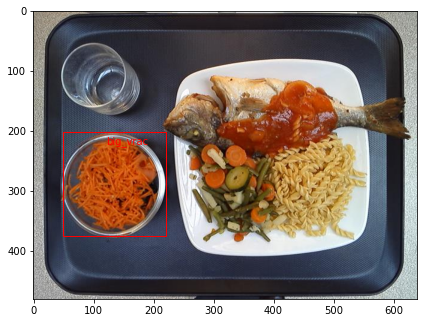

In [5]:
image_plot(image_directory,'im_0.jpg')

## Choice of the model

First, there is a problem of object detection : identifying the "salad and fruit bar" products. Then, here is also a classification problem considering the "small" and "big" products. Finally, we have to provide the bounding box for the "salad ans fruit bar", this is a localization problem. 

If there was only one object to localize by images I would compute a regression over a convolutionnal neural network that output the 4 coordinates of a square around the "salad & fruit bar". The point here is that there could be different amount of "salad & fruit bar" so we have to make the system intolerant to the number of objects to detect.

### RCNN
R-CNN stands for Region Convolutional Neural Network and compute by applying a ConvNet over extracted ROI (Regions of Interests). The regions are extracted using selective search algorithm then a ConvNet is used over each region to detect and classify objects (SVM).  

### Fast-RCNN
Fast-R-CNN begin with a ConvNet over the entire image and then compute the different regions, it saves time because it doesn’t apply a Convnet over each region. 

### Faster-RCNN
Faster-R-CNN is even more efficient than Fast-R-CNN using the network to learn the region proposal without using selective search which is time consuming. The image is processed through a ConvNet that output a feature map and a separate Network is used to extract regions. Then regions are reshaped and classified. 



### Training of Faster-RCNN

- filepath is the path of the training image
- x1 is the xmin coordinate for bounding box
- y1 is the ymin coordinate for bounding box
- x2 is the xmax coordinate for bounding box
- y2 is the ymax coordinate for bounding box
- class_name is the name of the class in that bounding box

In [6]:
# Prepare Dataset
data = pd.DataFrame(columns =['filepath','x1','y1','x2','y2','class_name'])

data['filepath'] = df['img'].map(lambda x : image_directory + x)
data ['x1'] = df['box'].map(lambda x : x[0])
data ['y1'] = df['box'].map(lambda x : x[1])
data ['x2'] = df['box'].map(lambda x : x[0]+x[2])
data ['y2'] = df['box'].map(lambda x : x[1]+x[3])
data ['class_name'] = df['id']

# Create a training and testing dataset
train=data.sample(frac=0.90,random_state=200) #random state is a seed value
test=data.drop(train.index)

train

,filepath,x1,y1,x2,y2,class_name
832,C:\Users\Quentin\Documents\WPy64-3760\notebook...,0,25,126,200,big_vrac
136,C:\Users\Quentin\Documents\WPy64-3760\notebook...,176,5,371,168,big_vrac
1128,C:\Users\Quentin\Documents\WPy64-3760\notebook...,323,156,496,327,big_vrac
503,C:\Users\Quentin\Documents\WPy64-3760\notebook...,103,153,278,322,big_vrac
827,C:\Users\Quentin\Documents\WPy64-3760\notebook...,50,56,208,214,small_vrac
...,...,...,...,...,...,...
84,C:\Users\Quentin\Documents\WPy64-3760\notebook...,485,8,640,174,small_vrac
707,C:\Users\Quentin\Documents\WPy64-3760\notebook...,276,77,433,250,small_vrac
387,C:\Users\Quentin\Documents\WPy64-3760\notebook...,444,48,621,225,big_vrac
998,C:\Users\Quentin\Documents\WPy64-3760\notebook...,259,14,416,171,small_vrac


In [7]:
#Save training data in a txt file
train.to_csv('data/training_data.txt', header=None, index=None, sep=',')

Then, we use the library provided on: https://github.com/kbardool/keras-frcnn  
<b>NB:</b> the library needs to be adapted to new versions of tensorflow and other dependants libraries.

to compute the training we have to launch:  
<i>
 cd keras-frcnn  
 python train_frcnn.py -o simple -p <b>$training_data_file</b> </i>

<b>$training_data_file</b> is a file containing our training dataset if the following format:  
<i>filepath,x1,y1,x2,y2,class_name</i>


### Testing of Faster-RCNN

to compute the testing we have to launch:  
<i>
 cd keras-frcnn  
 python test_frcnn.py -o simple -p <b>$test_data_file</b></i>
 
 <b>$test_data_file</b> is a file containing our testing dataset if the following format:  
 <i>filepath,x1,y1,x2,y2,class_name</i>

In [8]:
#Save testing data in a txt file
test.to_csv('data/testing_data.txt', header=None, index=None, sep=',')

The results of the training is then saved in a text file, images with located "salad and fruit bar" are also displayed in the folder "result_imgs".

In [16]:
#Extract the result of test
test_results = pd.read_csv('keras-frcnn/result_data.txt')
test_results

,image,x1,y1,x2,y2,class_name,proba
0,im_0.jpg,51,204,217,384,small_vrac,88
1,im_0.jpg,550,128,640,243,small_vrac,80
2,im_15.jpg,217,140,435,332,big_vrac,88
3,im_15.jpg,192,115,537,460,big_vrac,88
4,im_15.jpg,64,38,230,204,small_vrac,98
...,...,...,...,...,...,...,...
266,im_974.jpg,345,25,486,166,small_vrac,84
267,im_974.jpg,64,153,345,435,big_vrac,94
268,im_992.jpg,12,166,166,320,small_vrac,98
269,im_992.jpg,0,0,166,166,big_vrac,95


Text(0.5, 1.0, 'Predicted classes')

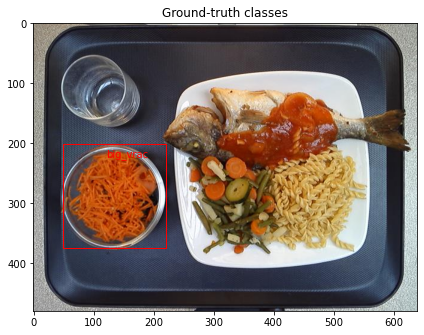

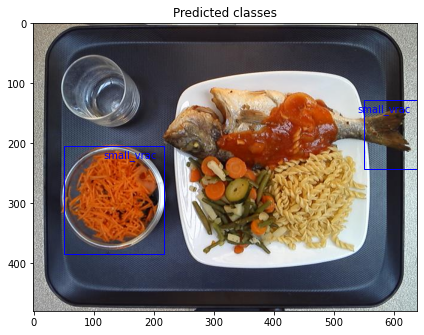

In [17]:
## plotting an example of prediction
im = test_results.iloc[1]['image']



# ground-truth image
image_plot(image_directory,im)
plt.title("Ground-truth classes")




# predicted image
fig = plt.figure()

## Add axes to the image
ax = fig.add_axes([0,0,1,1])

image = plt.imread(image_directory + im)
plt.imshow(image)

# Iterating over the image for different objects
for _,row in test_results[test_results['image'] == im].iterrows():
    xmin = row.x1
    xmax = row.x2
    ymin = row.y1
    ymax = row.y2

    width = xmax - xmin
    height = ymax - ymin

    # assign different color to different classes of objects
    if row.class_name == 'big_vrac':
        edgecolor = 'r'
        ax.annotate('big_vrac', xy=(xmax-100,ymin+20),c='r')
    elif row.class_name == 'small_vrac':
        edgecolor = 'b'
        ax.annotate('small_vrac', xy=(xmax-100,ymin+20),c='b')

    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')

    ax.add_patch(rect)
    
plt.title("Predicted classes")

### Evaluating detection

First, we will evaluate the capacity of detection of our model. We will compute the IoU of the bounding boxes (ground-truth vs predicted), without considering the classification issue.

To proceed, we will create our adapted files for ground-truth and prediction data.In these files each line should be in the format:  
                       <b>class_name left top right bottom</b>


In [18]:
#save files

# Current Time
Time = time.strftime("%I:%M:%S %p", time.localtime())[:-3].replace(':','-')

for _,row in test_results.iterrows():

    #filename
    FileName = row.image[:-4]+'-'+Time+'.txt'

    #savefile
    test_results[test_results['image']==row.image].to_csv('Object-Detection-Metrics/detections/'+ FileName,header=False,index=False,sep=" ",columns=["class_name","proba","x1","y1","x2","y2"])
    test[test['filepath'].str.contains(row.image)].to_csv('Object-Detection-Metrics/groundtruths/'+FileName,header=False,index=False,sep=" ",columns=["class_name","x1","y1","x2","y2"])
    

To evaluate the Average prediction we use the library (the IoU is computed with a treshold of 0.3):  

<i>python pascalvoc.py -detformat xyrb --imgsize 480,640 -t 0.3</i>

The results of the evaluation can be found in the folder <b>results</b>.